# Graph Neural Networks

In this notebook, we explore how to build neural networks to learn about the patterns that appear in data that can be represented as graphs. You can find a lot of useful examples and videos on the topic on the homepage of [pytorch-geometric](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html) as well as more information on the [installation](https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html) if you want to run pytorch-geometric on your own laptop. If you are interested in learning more about the concepts behind GNNs have a look at this [article](https://distill.pub/2021/understanding-gnns/) or this other [article](https://distill.pub/2021/gnn-intro/) on [distill.pub](https://distill.pub/).

<font color='red'><b>Exercise 1:</b></font> Pick one of the articles from distill.pub listed above and discuss them in the group.

In [2]:
import importlib
try:
    importlib.import_module("torch")
except ImportError:
    !pip install torch
try:
    importlib.import_module("torch_geometric")
except ImportError:
    !pip install torch-geometric

import torch
import torch.nn as nn
from torch.nn import Linear
import torch.optim as optim
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import KarateClub
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

The so-called Karate Club network data set includes a number of students who are associated with different clubs. The data set already exists in PyTorch, and we can import it directly into the correct format. If we want to plot the graph, we can convert the data set into a format that is readable for networkx. The outcome is shown below. The different colours signify the different associations of the students.

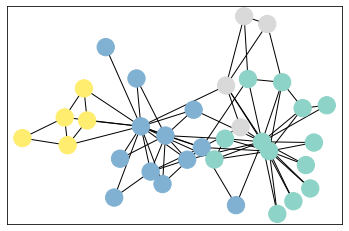

In [3]:
# Load the Karate Club network dataset
dataset = KarateClub()
data = dataset[0]

G = to_networkx(data, to_undirected=True)

nx.draw_networkx(G, pos=nx.spring_layout(G, seed=21), with_labels=False, node_color=data.y, cmap="Set3")

## Assigning club membership

What would we like to learn about this network? Knowing what question we want to address is necessary for picking a suitable network architecture and for determining a meaningful loss function. At first, let's see whether we can get the network to assign each student to the correct karate club. We are hence facing a classification task.

In [3]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, num_classes, hidden_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        output = self.conv2(h, edge_index)
        return output

In [4]:
model = GCN(dataset.num_features, dataset.num_classes, 4)

Since, we are interested in classificaton, the cross entropy would be our go-to loss function.

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Now, we can construct a training loop following the same logic as always:

- Perform a feedforward pass to compute the network predictions.
- Compute the loss
- Compute the gradients of the loss with respect to the parameters of the neural network.
- Update the parameters based on the gradients.

In [6]:
losses = []
outputs = []

for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()
    # Feedforward
    output = model(data.x, data.edge_index)
    # Compute loss
    loss = criterion(output, data.y)
    # Backpropagation
    loss.backward()
    # Optimise
    optimizer.step()

    losses.append(loss)
    outputs.append(output.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3}: Loss: {loss.item():.2f}')

Epoch   0: Loss: 1.40
Epoch  10: Loss: 1.31
Epoch  20: Loss: 1.24
Epoch  30: Loss: 1.15
Epoch  40: Loss: 1.03
Epoch  50: Loss: 0.88
Epoch  60: Loss: 0.73
Epoch  70: Loss: 0.60
Epoch  80: Loss: 0.49
Epoch  90: Loss: 0.39
Epoch 100: Loss: 0.32
Epoch 110: Loss: 0.26
Epoch 120: Loss: 0.22
Epoch 130: Loss: 0.19
Epoch 140: Loss: 0.16
Epoch 150: Loss: 0.14
Epoch 160: Loss: 0.13
Epoch 170: Loss: 0.11
Epoch 180: Loss: 0.10
Epoch 190: Loss: 0.09
Epoch 200: Loss: 0.08


Let's plot the predicted graph at different points of the optimisation process, i.e. from different epochs.

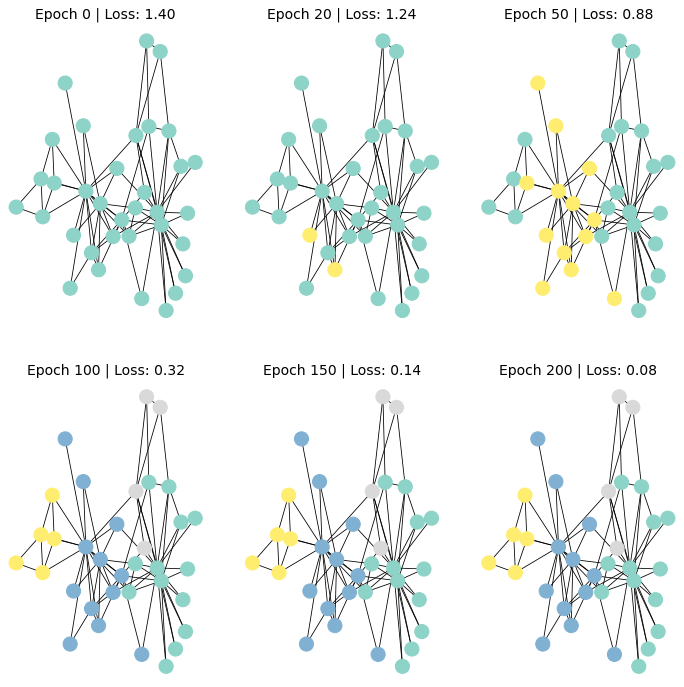

In [7]:
def plotting(i):
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=21),
                    node_size=200,
                    with_labels=False,
                    node_color=outputs[i],
                    cmap="Set3",
                    width=0.8,
                    )
    plt.axis('off')
    plt.title(f'Epoch {i} | Loss: {losses[i]:.2f}', fontsize=14, pad=10)

fig = plt.figure(figsize=(12, 12))
for j, i in enumerate([0,20,50,100,150,200]):
    plt.subplot(2,3,j+1)
    plotting(i)

As you can see, we converge to the right classification of the different clubs (the loss keeps decreasing even though the classification already looks right at epoch 100 because the network predicts probabilities, and we merely show the most probable class). So, if we had any data that was not already classified, containing people whose membership we didn't know, we would now have a tool that would be able to predict the most likely karate club for these students.

<font color='red'><b>Exercise 2:</b></font> In the [previous course on Deep Learning](https://github.com/ASoelvsten/RCDS-Deep-Learning-CNN), we learned how to transfer our model to GPUs when running our Google Colab notebooks. Can you add the necessary code to the example above?

## Another classification example

In the example above, I didn't include any testing. Indeed, since the data set is very small, maybe we could choose a better [dataset](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html) for this purpose. Let's look at the Cora dataset, which contains over 2700 scientific publications within seven different categories. We can load it like this (see also an example on the classification of this dataset on [Kaggle](https://www.kaggle.com/code/adilimadeddinehosni/gnn-based-node-classification-with-pytorch-geo)):

In [8]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]  # Get the first graph object.

Now, this dataset is already split into a training and a test set. Note that we only access a very small fraction of the nodes to train our model here.

In [9]:
print(f'The training set contains: {data.train_mask.sum()}')

The training set contains: 140


In [10]:
model = GCN(dataset.num_features, dataset.num_classes, 32)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

for epoch in range(1, 201):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Training loss: {loss:.4f}')

Epoch: 10 | Training loss: 1.8319
Epoch: 20 | Training loss: 1.5736
Epoch: 30 | Training loss: 1.2253
Epoch: 40 | Training loss: 0.8835
Epoch: 50 | Training loss: 0.6350
Epoch: 60 | Training loss: 0.4850
Epoch: 70 | Training loss: 0.3961
Epoch: 80 | Training loss: 0.3394
Epoch: 90 | Training loss: 0.3003
Epoch: 100 | Training loss: 0.2716
Epoch: 110 | Training loss: 0.2497
Epoch: 120 | Training loss: 0.2323
Epoch: 130 | Training loss: 0.2182
Epoch: 140 | Training loss: 0.2064
Epoch: 150 | Training loss: 0.1965
Epoch: 160 | Training loss: 0.1880
Epoch: 170 | Training loss: 0.1806
Epoch: 180 | Training loss: 0.1742
Epoch: 190 | Training loss: 0.1686
Epoch: 200 | Training loss: 0.1636


<font color='red'><b>Exercise 3:</b></font> Explain and discuss the training loop above.

<font color='red'><b>Exercise 4:</b></font> Apply the trained network to a testset. What is the accuracy with which nodes are assigned to the correct class?

<font color='red'><b>Exercise 5:</b></font> Plot the graph of the network that we are exploring in the example above.

## Link prediction

Rather than considering the nodes, we can focus on the edges: What node is connected to what node? For instance, consider a social network on social media. The information that one person is connected to a set of other people who are themselves connected might help us to provide recommendations for friend requests, i.e., we are interested in the probability that a person knows someone else in the social network even though they don't have a connection to this person yet. 

To have a look at this task, let's load a large dataset. In this particular example, we consider papers that cite each other and want to predict the probability that papers are connected even when citations don't exist.

In [11]:
from torch_geometric.datasets import CitationFull
from torch_geometric.utils import negative_sampling
from torch_geometric.transforms import RandomLinkSplit
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as transforms

dataset = CitationFull(root='data/CitationFull',name='PubMed')
data = dataset[0]

transform = transforms.Compose([
    transforms.NormalizeFeatures(),
    transforms.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])

train_data, val_data, test_data = transform(data)

Let's have a look at the training set.

In [12]:
train_data

Data(x=[19717, 500], edge_index=[2, 75352], y=[19717], edge_label=[37676], edge_label_index=[2, 37676])

As we can see, the training set includes 19,717 nodes with 500 features each. There are 75,352 edges in total, with  37,676 unique edge labels. To better understand the training set, note that the original dataset also contains 19,717 nodes, *but* it contains more edges. Basically, we withhold some of the edges for training. After all, we aim for the network to be able to spot edges that it has not been informed about.

We now want to build a neural network that can predict the existence of links. You can find examples of such networks on [Kaggle](https://www.kaggle.com/code/adilimadeddinehosni/graph-neural-netwotk-for-link-prediction) or in the original example by [pytorch-geometric](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py). As you can see from these examples, the prediction of links is performed using a VAE setup.

In [13]:
class LinkPredictionNet(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

Before we proceed, let's discuss the code above in a bit more detail. As discussed in the introductory lecture series, a VAE first projects the data into a lower dimensional latent space (encoding), whereafter, it brings the result in the latent space back into the original space (decoding). 

To understand this better, let's dive a bit deeper into the code. Let's start with the encoder. The GCNConv layers learn to aggregate information from a node's neighbours in a graph, i.e., they are responsible for bringing us into the latent space. For graph neural networks, we say that they create an embedding and that these embeddings encode structural information and properties of nodes and their neighbourhoods in the graph.

Let's now turn our attention to the decoder. Here, we take the dot product of the embeddings, summing over the last dimension, which gives us a probability for an edge between the corresponding nodes. To understand the connection between the node embeddings and probabilities of edges (links), you need to know that each dimension of the embedding corresponds to different features or aspects of the node. Summing over the last dimension aggregates information from all features of the node embeddings, capturing their overall similarity or compatibility for forming an edge. We can thus use this quantity as a proxy for the probability of an edge between corresponding nodes in a graph.

In [14]:
model =  LinkPredictionNet(dataset.num_features, 128, 64)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

Note that we changed the loss function: We now use the Binary Cross Entropy that allows us to output probabilities between 0 and 1. The reason is that we are facing a binary classification task: Either the link is there, or it isn't, and our task is to compute the probability of its existence.

Before we can write the training loop, we have to consider the nature of the data: All the edges (links) that are contained in our dataset exist. If we were to train our network solely on these data, it would learn that edges *always* exist, as any edge that it encounters does. That's no good. So, we need to present the network with counterfactual edges that it will have to discard. For every epoch, we thus sample a random set of non-existing edges (negative sampling).   

In [15]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # We perform a new round of negative sampling for every training epoch:
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index)
    out = out.view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

for epoch in range(1, 101):
    loss = train()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch} | Training loss: {loss:.4f}')

Epoch: 10 | Training loss: 0.6475
Epoch: 20 | Training loss: 0.6122
Epoch: 30 | Training loss: 0.5923
Epoch: 40 | Training loss: 0.5244
Epoch: 50 | Training loss: 0.5018
Epoch: 60 | Training loss: 0.4831
Epoch: 70 | Training loss: 0.4700
Epoch: 80 | Training loss: 0.4566
Epoch: 90 | Training loss: 0.4572
Epoch: 100 | Training loss: 0.4544


<font color='red'><b>Exercise 6:</b></font> I didn't make use of the validation data above. Can you add validation to the training loop as well as early stopping? (If you need any help, have a look at the aforementioned [PyTorch example](https://github.com/pyg-team/pytorch_geometric/blob/master/examples/link_pred.py)).

<font color='red'><b>Exercise 7:</b></font> Include code for testing the performance of the network.

For an alternative example and architecture, see this [PyTorch notebook](https://colab.research.google.com/drive/1xpzn1Nvai1ygd_P5Yambc_oe4VBPK_ZT?usp=sharing).

## GAT

So-called Graph Attention Networks (GAT) have another key component: An attention mechanism. Instead of treating all neighbouring nodes equally, GATs assign attention scores to each neighbour dynamically. These attention scores are learned during the training process and determine the importance of each neighbour in updating the representation of the central node. A normal GCN can be seen as a special case of a GAT with fixed attention. In other words, while the attention scores of a GAT are adaptive, the attention of a normal GCN has been set to equal the weights of each edge (see also [Wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network) or the homepage of [Petar Veličković](https://petar-v.com/GAT/) for a more mathematical introduction to the concept of attention in GNNs).

Since we are extending our previous framework by introducing attention to the graph convolutional layers, all we really have to do to turn our GCN into a GAT is to replace GCNConv with GATConv.

In [16]:
from torch_geometric.nn import GATConv

# Define the GAT model
class GAT(nn.Module):
    def __init__(self, in_features, hidden_dim, num_classes, num_heads):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_features, hidden_dim, heads=num_heads)
        self.conv2 = GATConv(hidden_dim * num_heads, num_classes, heads=1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

Note that we made additional changes. First, we introduced dropout, which you met in the introductory course (what was dropout). We do so to avoid overfitting. Secondly, we introduce F.log_softmax(), turning logits into log-probabilities. You will find this set up in quite a few [example](https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html)s. Consequently, as our output is now probabilities, we need another loss function: [nll_loss](https://pytorch.org/docs/stable/generated/torch.nn.functional.nll_loss.html).

<font color='red'><b>Exercise 8:</b></font> Having defined the neural network architecture of our GAT, you should be able to train it for classification. Give it a try.

## External data

Consider the case where you have created your own graph based on a dataset and you want to apply a GNN. How do you convert your data to the right format? To have a look at this, let's start out by creating a synthetic dataset.

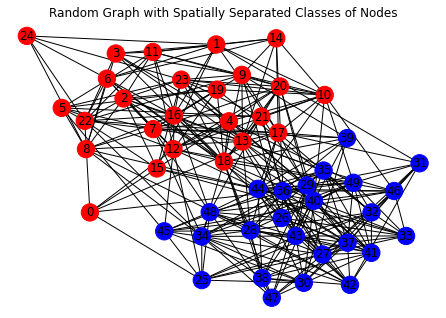

In [17]:
import random
from torch_geometric.utils.convert import from_networkx

# Create an empty graph
G = nx.Graph()

# Define the number of nodes
num_nodes = 50

# Define the number of nodes for each class
num_class1 = num_nodes // 2
num_class2 = num_nodes - num_class1

# Define the number of features per node
num_features_per_node = 3

# Add nodes to the graph with their classes saved in the 'y' attribute
for i in range(num_class1):
    G.add_node(i, y=0, x=[2+random.random() for _ in range(num_features_per_node)])  # Adding node features directly
for i in range(num_class1, num_nodes):
    G.add_node(i, y=1, x=[random.random() for _ in range(num_features_per_node)])  # Adding node features directly

# Add edges between nodes with a higher probability of connecting within the same class
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if G.nodes[i]['y'] == G.nodes[j]['y']:  # If nodes belong to the same class
            if random.random() < 0.4:  # Higher probability of connecting within the same class
                G.add_edge(i, j)
        else:
            if random.random() < 0.1:  # Lower probability of connecting between different classes
                G.add_edge(i, j)

# Draw the graph
pos = nx.spring_layout(G)  # Layout for better visualization
nx.draw(G, pos, with_labels=True, node_color=[{0: 'red', 1: 'blue'}[G.nodes[node]['y']] for node in G.nodes()])
plt.title('Random Graph with Spatially Separated Classes of Nodes')
plt.show()

Now we can convert this graph to the format needed by PyTorch.

In [18]:
# Convert the graph into PyTorch geometric
data = from_networkx(G)
data.num_features = num_features_per_node
data.num_classes = 2

You could now train a neural network classifier on this data.

<font color='red'><b>Exercise 9:</b></font> Check out the datasets on [https://ogb.stanford.edu/docs/home/](https://ogb.stanford.edu/docs/home/).

Data can come from anywhere as you can view many different types of data, ranging from [images](https://pypi.org/project/imgraph/) to [point clouds]( https://colab.research.google.com/drive/1D45E5bUK3gQ40YpZo65ozs7hg5l-eo_U?usp=sharing), as graphs.

## What else?

Above we have gone through a few examples. We covered

- **Node Classification:** GNNs can classify nodes in a graph based on their features and relationships with other nodes. This is useful in social network analysis, where nodes represent users, and the task is to predict user attributes or behavior.

- **Link Prediction:** GNNs can predict the presence or absence of edges between pairs of nodes in a graph. This is valuable in recommendation systems, where the goal is to suggest connections or collaborations between entities based on their similarities or interactions.

But what else might you want to know if you have a graph?

- **Graph Classification:** GNNs can classify entire graphs based on their structural properties and node features. This is applicable in bioinformatics, where graphs represent molecular structures, and the task is to classify compounds based on their properties or activities.

- **Community Detection:** GNNs can identify communities or clusters of nodes within a graph based on their connectivity patterns. This is useful in social network analysis, where the goal is to uncover cohesive groups of users with similar interests or affiliations.

- **Anomaly Detection:** GNNs can detect anomalies or outliers in graph-structured data by learning representations that capture normal patterns and dependencies within the graph. This is valuable in cybersecurity, where the task is to identify suspicious activities or behaviors in networks.

Putting all of these things together, we can, e.g., construct recommendation systems providing personalized recommendations based on users' preferences and item characteristics, perform Natural Language Processing (NLP), or predict traffic flow or congestion patterns.

## What about evolving systems?

The example of traffic mentioned above is a fascinating application of GNNs, because traffic *flows*, i.e., the graph isn't static. It's time-dependent. To handle this type of problem, we can make use of an extension of the pytorch-geometric library: [pytorch-geometric-temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/modules/root.html).

<font color='red'><b>Exercise 10:</b></font> What is a recurrent graph neural network?

<font color='red'><b>Exercise 11:</b></font> Explore the [applications of pytorch-geometric-temporal](https://pytorch-geometric-temporal.readthedocs.io/en/latest/notes/introduction.html#applications) (both epidemiological forecasting and web traffic prediction). Discuss the code in the group.